In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "int99"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 288
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 360
Categorical Columns: 8


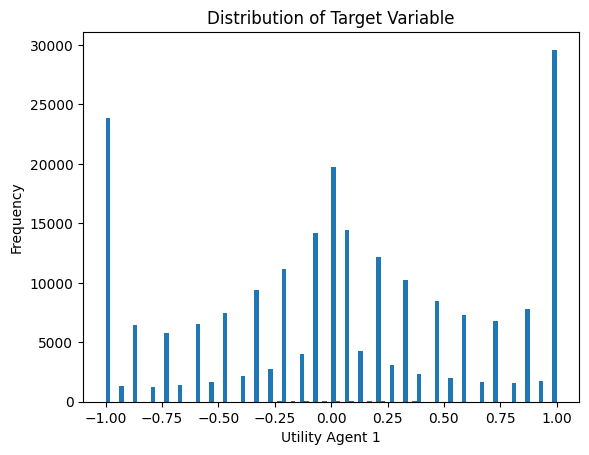

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55371


[100]	val-rmse:0.46825


[200]	val-rmse:0.45025


[300]	val-rmse:0.44215


[400]	val-rmse:0.43723


[500]	val-rmse:0.43437


[600]	val-rmse:0.43214


[700]	val-rmse:0.43087


[800]	val-rmse:0.42979


[900]	val-rmse:0.42908


[1000]	val-rmse:0.42843


[1100]	val-rmse:0.42803


[1200]	val-rmse:0.42759


[1300]	val-rmse:0.42728


[1400]	val-rmse:0.42700


[1500]	val-rmse:0.42685


[1600]	val-rmse:0.42654


[1700]	val-rmse:0.42634


[1800]	val-rmse:0.42630


[1900]	val-rmse:0.42630


[2000]	val-rmse:0.42616


[2100]	val-rmse:0.42610


[2200]	val-rmse:0.42605


[2300]	val-rmse:0.42611


[2400]	val-rmse:0.42618


[2499]	val-rmse:0.42619


Fold 1 - RMSE: 0.4258588177580452
Fold 2


[0]	val-rmse:0.58854


[100]	val-rmse:0.48190


[200]	val-rmse:0.46560


[300]	val-rmse:0.46019


[400]	val-rmse:0.45655


[500]	val-rmse:0.45428


[600]	val-rmse:0.45262


[700]	val-rmse:0.45157


[800]	val-rmse:0.45070


[900]	val-rmse:0.45008


[1000]	val-rmse:0.44965


[1100]	val-rmse:0.44935


[1200]	val-rmse:0.44915


[1300]	val-rmse:0.44885


[1400]	val-rmse:0.44878


[1500]	val-rmse:0.44846


[1600]	val-rmse:0.44815


[1700]	val-rmse:0.44810


[1800]	val-rmse:0.44797


[1900]	val-rmse:0.44783


[2000]	val-rmse:0.44774


[2100]	val-rmse:0.44764


[2200]	val-rmse:0.44766


[2300]	val-rmse:0.44768


[2400]	val-rmse:0.44769


[2499]	val-rmse:0.44773


Fold 2 - RMSE: 0.44737098503616196
Fold 3


[0]	val-rmse:0.60603


[100]	val-rmse:0.48277


[200]	val-rmse:0.46247


[300]	val-rmse:0.45582


[400]	val-rmse:0.45182


[500]	val-rmse:0.44960


[600]	val-rmse:0.44784


[700]	val-rmse:0.44677


[800]	val-rmse:0.44595


[900]	val-rmse:0.44562


[1000]	val-rmse:0.44523


[1100]	val-rmse:0.44482


[1200]	val-rmse:0.44448


[1300]	val-rmse:0.44429


[1400]	val-rmse:0.44431


[1500]	val-rmse:0.44419


[1600]	val-rmse:0.44409


[1700]	val-rmse:0.44383


[1800]	val-rmse:0.44373


[1900]	val-rmse:0.44366


[2000]	val-rmse:0.44358


[2100]	val-rmse:0.44364


[2200]	val-rmse:0.44353


[2300]	val-rmse:0.44355


[2400]	val-rmse:0.44355


[2499]	val-rmse:0.44363


Fold 3 - RMSE: 0.4431956767123408
Fold 4


[0]	val-rmse:0.59606


[100]	val-rmse:0.48371


[200]	val-rmse:0.46437


[300]	val-rmse:0.45746


[400]	val-rmse:0.45222


[500]	val-rmse:0.44881


[600]	val-rmse:0.44725


[700]	val-rmse:0.44554


[800]	val-rmse:0.44440


[900]	val-rmse:0.44337


[1000]	val-rmse:0.44268


[1100]	val-rmse:0.44225


[1200]	val-rmse:0.44180


[1300]	val-rmse:0.44144


[1400]	val-rmse:0.44116


[1500]	val-rmse:0.44068


[1600]	val-rmse:0.44055


[1700]	val-rmse:0.44028


[1800]	val-rmse:0.44023


[1900]	val-rmse:0.44011


[2000]	val-rmse:0.44005


[2100]	val-rmse:0.43992


[2200]	val-rmse:0.43973


[2300]	val-rmse:0.43975


[2400]	val-rmse:0.43982


[2499]	val-rmse:0.43975


Fold 4 - RMSE: 0.43929088977730146
Fold 5


[0]	val-rmse:0.54691


[100]	val-rmse:0.45701


[200]	val-rmse:0.43679


[300]	val-rmse:0.42748


[400]	val-rmse:0.42155


[500]	val-rmse:0.41772


[600]	val-rmse:0.41547


[700]	val-rmse:0.41373


[800]	val-rmse:0.41274


[900]	val-rmse:0.41188


[1000]	val-rmse:0.41125


[1100]	val-rmse:0.41095


[1200]	val-rmse:0.41050


[1300]	val-rmse:0.41017


[1400]	val-rmse:0.41010


[1500]	val-rmse:0.40971


[1600]	val-rmse:0.40949


[1700]	val-rmse:0.40938


[1800]	val-rmse:0.40941


[1900]	val-rmse:0.40927


[2000]	val-rmse:0.40920


[2100]	val-rmse:0.40906


[2200]	val-rmse:0.40920


[2300]	val-rmse:0.40930


[2400]	val-rmse:0.40934


[2499]	val-rmse:0.40933


Fold 5 - RMSE: 0.4090204472968267
List of oof scores: [0.4258588177580452, 0.44737098503616196, 0.4431956767123408, 0.43929088977730146, 0.4090204472968267]
Average oof score: 0.4329473633161352


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53533


[100]	val-rmse:0.45159


[200]	val-rmse:0.43641


[300]	val-rmse:0.42967


[400]	val-rmse:0.42553


[500]	val-rmse:0.42247


[600]	val-rmse:0.42049


[700]	val-rmse:0.41892


[800]	val-rmse:0.41776


[900]	val-rmse:0.41674


[1000]	val-rmse:0.41612


[1100]	val-rmse:0.41565


[1200]	val-rmse:0.41508


[1300]	val-rmse:0.41479


[1400]	val-rmse:0.41459


[1500]	val-rmse:0.41425


[1600]	val-rmse:0.41421


[1700]	val-rmse:0.41413


[1800]	val-rmse:0.41405


[1900]	val-rmse:0.41408


[2000]	val-rmse:0.41403


[2100]	val-rmse:0.41383


[2200]	val-rmse:0.41372


[2300]	val-rmse:0.41368


[2400]	val-rmse:0.41361


[2499]	val-rmse:0.41358


Fold 1 - RMSE: 0.41335223585837794
Fold 2


[0]	val-rmse:0.54719


[100]	val-rmse:0.43553


[200]	val-rmse:0.42009


[300]	val-rmse:0.41455


[400]	val-rmse:0.41169


[500]	val-rmse:0.40992


[600]	val-rmse:0.40865


[700]	val-rmse:0.40809


[800]	val-rmse:0.40755


[900]	val-rmse:0.40729


[1000]	val-rmse:0.40725


[1100]	val-rmse:0.40699


[1200]	val-rmse:0.40700


[1300]	val-rmse:0.40705


[1400]	val-rmse:0.40718


[1500]	val-rmse:0.40714


[1600]	val-rmse:0.40730


[1700]	val-rmse:0.40743


[1800]	val-rmse:0.40751


[1900]	val-rmse:0.40758


[2000]	val-rmse:0.40757


[2100]	val-rmse:0.40759


[2200]	val-rmse:0.40753


[2300]	val-rmse:0.40749


[2400]	val-rmse:0.40760


[2499]	val-rmse:0.40763


Fold 2 - RMSE: 0.4072000044678591
Fold 3


[0]	val-rmse:0.61316


[100]	val-rmse:0.48807


[200]	val-rmse:0.46431


[300]	val-rmse:0.45490


[400]	val-rmse:0.44940


[500]	val-rmse:0.44558


[600]	val-rmse:0.44318


[700]	val-rmse:0.44120


[800]	val-rmse:0.43992


[900]	val-rmse:0.43879


[1000]	val-rmse:0.43817


[1100]	val-rmse:0.43738


[1200]	val-rmse:0.43698


[1300]	val-rmse:0.43631


[1400]	val-rmse:0.43591


[1500]	val-rmse:0.43547


[1600]	val-rmse:0.43524


[1700]	val-rmse:0.43500


[1800]	val-rmse:0.43467


[1900]	val-rmse:0.43456


[2000]	val-rmse:0.43446


[2100]	val-rmse:0.43427


[2200]	val-rmse:0.43417


[2300]	val-rmse:0.43419


[2400]	val-rmse:0.43408


[2499]	val-rmse:0.43393


Fold 3 - RMSE: 0.4335777781424969
Fold 4


[0]	val-rmse:0.60682


[100]	val-rmse:0.49244


[200]	val-rmse:0.46960


[300]	val-rmse:0.46063


[400]	val-rmse:0.45621


[500]	val-rmse:0.45298


[600]	val-rmse:0.45096


[700]	val-rmse:0.44943


[800]	val-rmse:0.44835


[900]	val-rmse:0.44796


[1000]	val-rmse:0.44761


[1100]	val-rmse:0.44693


[1200]	val-rmse:0.44662


[1300]	val-rmse:0.44608


[1400]	val-rmse:0.44598


[1500]	val-rmse:0.44572


[1600]	val-rmse:0.44569


[1700]	val-rmse:0.44562


[1800]	val-rmse:0.44556


[1900]	val-rmse:0.44550


[2000]	val-rmse:0.44543


[2100]	val-rmse:0.44548


[2200]	val-rmse:0.44540


[2300]	val-rmse:0.44530


[2400]	val-rmse:0.44519


[2499]	val-rmse:0.44508


Fold 4 - RMSE: 0.4447776657348215
Fold 5


[0]	val-rmse:0.59112


[100]	val-rmse:0.48727


[200]	val-rmse:0.46472


[300]	val-rmse:0.45624


[400]	val-rmse:0.45060


[500]	val-rmse:0.44687


[600]	val-rmse:0.44490


[700]	val-rmse:0.44357


[800]	val-rmse:0.44259


[900]	val-rmse:0.44181


[1000]	val-rmse:0.44131


[1100]	val-rmse:0.44089


[1200]	val-rmse:0.44045


[1300]	val-rmse:0.44017


[1400]	val-rmse:0.43999


[1500]	val-rmse:0.43966


[1600]	val-rmse:0.43946


[1700]	val-rmse:0.43938


[1800]	val-rmse:0.43930


[1900]	val-rmse:0.43906


[2000]	val-rmse:0.43896


[2100]	val-rmse:0.43881


[2200]	val-rmse:0.43872


[2300]	val-rmse:0.43877


[2400]	val-rmse:0.43875


[2499]	val-rmse:0.43876


Fold 5 - RMSE: 0.4382737932691715
List of oof scores: [0.41335223585837794, 0.4072000044678591, 0.4335777781424969, 0.4447776657348215, 0.4382737932691715]
Average oof score: 0.4274362954945454


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57528


[100]	val-rmse:0.47884


[200]	val-rmse:0.45906


[300]	val-rmse:0.45174


[400]	val-rmse:0.44758


[500]	val-rmse:0.44479


[600]	val-rmse:0.44314


[700]	val-rmse:0.44197


[800]	val-rmse:0.44124


[900]	val-rmse:0.44070


[1000]	val-rmse:0.44021


[1100]	val-rmse:0.44002


[1200]	val-rmse:0.43968


[1300]	val-rmse:0.43955


[1400]	val-rmse:0.43937


[1500]	val-rmse:0.43927


[1600]	val-rmse:0.43913


[1700]	val-rmse:0.43908


[1800]	val-rmse:0.43887


[1900]	val-rmse:0.43882


[2000]	val-rmse:0.43879


[2100]	val-rmse:0.43872


[2200]	val-rmse:0.43863


[2300]	val-rmse:0.43858


[2400]	val-rmse:0.43855


[2499]	val-rmse:0.43855


Fold 1 - RMSE: 0.438105916435846
Fold 2


[0]	val-rmse:0.57465


[100]	val-rmse:0.46828


[200]	val-rmse:0.44489


[300]	val-rmse:0.43554


[400]	val-rmse:0.42869


[500]	val-rmse:0.42429


[600]	val-rmse:0.42170


[700]	val-rmse:0.41980


[800]	val-rmse:0.41889


[900]	val-rmse:0.41779


[1000]	val-rmse:0.41706


[1100]	val-rmse:0.41646


[1200]	val-rmse:0.41598


[1300]	val-rmse:0.41558


[1400]	val-rmse:0.41530


[1500]	val-rmse:0.41491


[1600]	val-rmse:0.41468


[1700]	val-rmse:0.41446


[1800]	val-rmse:0.41436


[1900]	val-rmse:0.41418


[2000]	val-rmse:0.41403


[2100]	val-rmse:0.41386


[2200]	val-rmse:0.41371


[2300]	val-rmse:0.41368


[2400]	val-rmse:0.41377


[2499]	val-rmse:0.41371


Fold 2 - RMSE: 0.4134288875850789
Fold 3


[0]	val-rmse:0.57647


[100]	val-rmse:0.46869


[200]	val-rmse:0.45244


[300]	val-rmse:0.44610


[400]	val-rmse:0.44268


[500]	val-rmse:0.43996


[600]	val-rmse:0.43871


[700]	val-rmse:0.43761


[800]	val-rmse:0.43651


[900]	val-rmse:0.43589


[1000]	val-rmse:0.43518


[1100]	val-rmse:0.43473


[1200]	val-rmse:0.43435


[1300]	val-rmse:0.43414


[1400]	val-rmse:0.43395


[1500]	val-rmse:0.43380


[1600]	val-rmse:0.43364


[1700]	val-rmse:0.43341


[1800]	val-rmse:0.43336


[1900]	val-rmse:0.43330


[2000]	val-rmse:0.43328


[2100]	val-rmse:0.43312


[2200]	val-rmse:0.43301


[2300]	val-rmse:0.43306


[2400]	val-rmse:0.43317


[2499]	val-rmse:0.43299


Fold 3 - RMSE: 0.4326978555936766
Fold 4


[0]	val-rmse:0.57573


[100]	val-rmse:0.46126


[200]	val-rmse:0.44367


[300]	val-rmse:0.43789


[400]	val-rmse:0.43290


[500]	val-rmse:0.42940


[600]	val-rmse:0.42740


[700]	val-rmse:0.42624


[800]	val-rmse:0.42545


[900]	val-rmse:0.42488


[1000]	val-rmse:0.42440


[1100]	val-rmse:0.42402


[1200]	val-rmse:0.42374


[1300]	val-rmse:0.42348


[1400]	val-rmse:0.42320


[1500]	val-rmse:0.42301


[1600]	val-rmse:0.42288


[1700]	val-rmse:0.42275


[1800]	val-rmse:0.42264


[1900]	val-rmse:0.42265


[2000]	val-rmse:0.42260


[2100]	val-rmse:0.42241


[2200]	val-rmse:0.42230


[2300]	val-rmse:0.42234


[2400]	val-rmse:0.42226


[2499]	val-rmse:0.42230


Fold 4 - RMSE: 0.421923242239739
Fold 5


[0]	val-rmse:0.58601


[100]	val-rmse:0.47688


[200]	val-rmse:0.45802


[300]	val-rmse:0.44953


[400]	val-rmse:0.44416


[500]	val-rmse:0.44029


[600]	val-rmse:0.43779


[700]	val-rmse:0.43610


[800]	val-rmse:0.43489


[900]	val-rmse:0.43390


[1000]	val-rmse:0.43334


[1100]	val-rmse:0.43267


[1200]	val-rmse:0.43224


[1300]	val-rmse:0.43197


[1400]	val-rmse:0.43174


[1500]	val-rmse:0.43151


[1600]	val-rmse:0.43129


[1700]	val-rmse:0.43114


[1800]	val-rmse:0.43102


[1900]	val-rmse:0.43076


[2000]	val-rmse:0.43068


[2100]	val-rmse:0.43070


[2200]	val-rmse:0.43066


[2300]	val-rmse:0.43070


[2400]	val-rmse:0.43072


[2499]	val-rmse:0.43063


Fold 5 - RMSE: 0.43032559167607426
List of oof scores: [0.438105916435846, 0.4134288875850789, 0.4326978555936766, 0.421923242239739, 0.43032559167607426]
Average oof score: 0.42729629870608293


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4259
Score: 0.4474
Score: 0.4432
Score: 0.4393
Score: 0.4090
Average CV1 Score: 0.4329

CV2 OOF Scores:
Score: 0.4134
Score: 0.4072
Score: 0.4336
Score: 0.4448
Score: 0.4383
Average CV2 Score: 0.4274

CV3 OOF Scores:
Score: 0.4381
Score: 0.4134
Score: 0.4327
Score: 0.4219
Score: 0.4303
Average CV3 Score: 0.4273


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

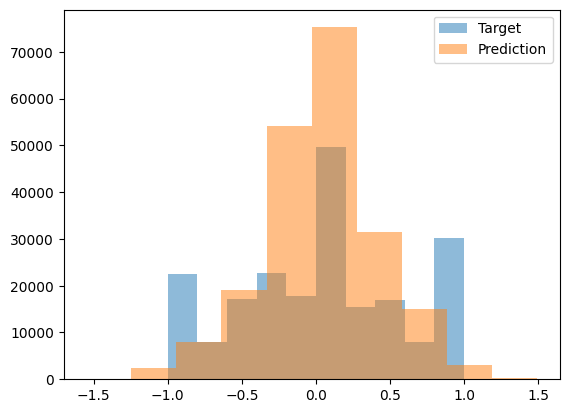

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***